In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [18]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('./data/BTC-USD.csv')

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(value):
    if isinstance(value, str):
        return float(value.replace(',', ''))
    else:
        return float(value)

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Close'] = data['Close'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Close']

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
price = data['Close'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [20]:
# Chia dữ liệu thành train test validate
train_size = int(len(df1) * 0.6)
test_size = int(len(df1) * 0.2)
val_size = len(df1) - train_size - test_size

In [21]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)
X_val, Y_val = create_dataset(val_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [23]:
# Xây dựng mô hình
model = Sequential()

In [24]:
# Thêm lớp tích chập (Convolution Layer)
model.add(Conv1D(filters=256, kernel_size=3, activation='ReLU', input_shape=(look_back, 1))) #rectified linear unit (ReLU)
model.add(Conv1D(filters=128, kernel_size=3, activation='ReLU'))
model.add(Conv1D(filters=64, kernel_size=3, activation='ReLU'))
model.add(Conv1D(filters=32, kernel_size=3, activation='ReLU'))
model.add(Conv1D(filters=1, kernel_size=3, activation='ReLU'))

In [25]:
# Thêm tầng average pooling
model.add(GlobalAveragePooling1D())

In [26]:
# Biên dịch mô hình Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val))

Epoch 1/50
20/20 [==============================] - 2s 56ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 2/50
20/20 [==============================] - 1s 70ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 3/50
20/20 [==============================] - 1s 71ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 4/50
20/20 [==============================] - 1s 71ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 5/50
20/20 [==============================] - 1s 51ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 6/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 7/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 8/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 9/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 10/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0769 - val_loss: 0.1225
Epoch 11/

In [28]:
# Dự báo
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
val_predict = scaler.inverse_transform(val_predict)
Y_val = scaler.inverse_transform([Y_val])

13/13 [==============================] - 0s 8ms/step


In [29]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 38791.21920376223
MAPE trên tập test là: 90.80917978953464 %
MDA trên tập test là: 0.0 %


In [30]:
# Dự báo giá trị 100 ngày trong tương lai
last_100_days = price_scaled[-100:]
next_100_days = []
for i in range(100):
    x = last_100_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_100_days.append(y_hat)
    last_100_days = np.append(last_100_days, y_hat, axis=0)

next_100_days = np.array(next_100_days).reshape(-1, 1)
next_100_days = scaler.inverse_transform(next_100_days)

print(next_100_days)

1/1 [==============================] - 0s 23ms/step
[[3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]
 [3236.7617]

In [31]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index

val_predict_df = pd.DataFrame(val_predict)
val_predict_index = range(len(train_data)+len(test_data)+look_back, len(train_data)+len(test_data)+look_back+len(val_predict))
val_predict_df.index = val_predict_index

next_100_days_df = pd.DataFrame(next_100_days)
next_100_index = range(len(data), len(data)+len(next_100_days))
next_100_days_df.index = next_100_index

train_data_df = data[:train_size][['Close']]
test_data_df = data[train_size:train_size + test_size][['Close']]
val_data_df = data[train_size+test_size:][['Close']]

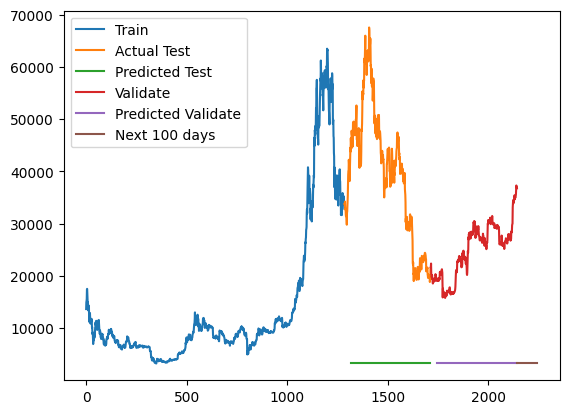

In [32]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 100 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(val_data_df, label='Validate')
plt.plot(val_predict_df, label='Predicted Validate')
plt.plot(next_100_days_df, label='Next 100 days')
plt.legend()
plt.show()